<a href="https://colab.research.google.com/github/sherry-ml/EVA7/blob/main/Session_9_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Required Libraries, Classes and Functions

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from tqdm import tqdm
import torch.nn as nn
import numpy as  np

In [2]:
!pip install torchsummary
from torchsummary import summary

In [3]:
!pip install torch-lr-finder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 102 kB 11.3 MB/s 
     |████████████████████████████████| 47.6 MB 1.8 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Pull in the code library from repo

In [6]:
!git clone https://github.com/sherry-ml/deep_dream_code.git

Cloning into 'deep_dream_code'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 232 (delta 128), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (232/232), 56.22 KiB | 5.62 MiB/s, done.
Resolving deltas: 100% (128/128), done.


Import Custom Functions, Classes

In [7]:
from deep_dream_code.models import custom_resnet
from deep_dream_code.models.custom_resnet import Custom_ResNet

In [8]:
from deep_dream_code import main, utils

In [9]:
from deep_dream_code.main import train, test, train_test_model

In [10]:
from deep_dream_code.utils import default_DL, C_10_DS, set_compose_params, tl_ts_mod, generate_gradcam, plot_gradcam
from deep_dream_code.utils import show_sample_img, torch_device, view_model_summary,display_incorrect_images,show_plots

In [11]:
from deep_dream_code.code_factory import OCLR_lr_finder

In [12]:
from deep_dream_code.code_factory.OCLR_lr_finder import find_lr

In [13]:
from deep_dream_code.code_factory import tune_lr_train_model
from deep_dream_code.code_factory.tune_lr_train_model import pipeline_tune_lr_train_model

Load Default dataset without any transformation(except tensor transformation)

In [14]:
trl, trs = default_DL()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show sample images from default dataset

  dog   dog horse plane


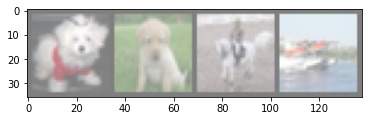

In [15]:
show_sample_img(trl, classes,10)

Calculate mean and std deviation of different channels from default dataset

In [16]:
mean = list(np.round(trs.data.mean(axis=(0,1,2))/255, 4))
mean

[0.4914, 0.4822, 0.4465]

In [17]:
std = list(np.round(trs.data.std(axis=(0,1,2))/255,4))
std

[0.247, 0.2435, 0.2616]

Setting transformation parameters and applying to CIFAR10 dataset

In [18]:
transform_train, transform_valid = set_compose_params(mean, std)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [19]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod = tl_ts_mod(transform_train,transform_valid)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
len(testset_mod), len(trainset_mod)


(10000, 50000)

Show sample images from CIFAR10 dataset with transformation applied

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird plane   dog truck   car


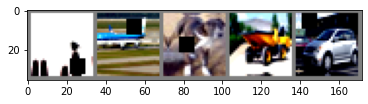

In [21]:
show_sample_img(trainloader_mod, classes,5)  

In [22]:
features, labels = next(iter(trainloader_mod))
features.shape, labels.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512]))

In [23]:
device = torch_device(torch.cuda.is_available())
print(f'From main notebook device:  {device}')

cuda
From main notebook device:  cuda


Printing Model Summary

In [24]:
test_model = Custom_ResNet()

In [25]:
view_model_summary(test_model, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

#################Running find_lr for lr 0.012


  0%|          | 0/480 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.53E-03


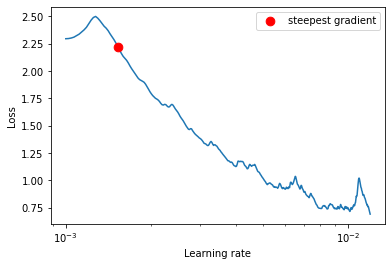

######Value of lrmax is 0.012
Custom_ResNet(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.0, inplace=False)
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout2d(p=0.0, inplace=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4):

100%|██████████| 98/98 [00:14<00:00,  6.61it/s]


 Average Training Loss=1.627037998046875, Accuracy=42.88



Test set: Average loss: 1.2120, Accuracy: 5689/10000 (56.89%)

EPOCH: 1


100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


 Average Training Loss=1.0473046661376952, Accuracy=62.912



Test set: Average loss: 0.8955, Accuracy: 6893/10000 (68.93%)

EPOCH: 2


100%|██████████| 98/98 [00:14<00:00,  6.60it/s]


 Average Training Loss=0.8063484014892578, Accuracy=72.016



Test set: Average loss: 0.8323, Accuracy: 7290/10000 (72.90%)

EPOCH: 3


100%|██████████| 98/98 [00:14<00:00,  6.54it/s]


 Average Training Loss=0.7111358291625977, Accuracy=76.052



Test set: Average loss: 0.6493, Accuracy: 7821/10000 (78.21%)

EPOCH: 4


100%|██████████| 98/98 [00:14<00:00,  6.60it/s]


 Average Training Loss=0.5879294192504882, Accuracy=80.058



Test set: Average loss: 0.5936, Accuracy: 7966/10000 (79.66%)

EPOCH: 5


100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


 Average Training Loss=0.5007593142700195, Accuracy=82.932



Test set: Average loss: 0.4589, Accuracy: 8451/10000 (84.51%)

EPOCH: 6


100%|██████████| 98/98 [00:14<00:00,  6.59it/s]


 Average Training Loss=0.4039706994628906, Accuracy=86.104



Test set: Average loss: 0.6748, Accuracy: 7900/10000 (79.00%)

EPOCH: 7


100%|██████████| 98/98 [00:14<00:00,  6.57it/s]


 Average Training Loss=0.3625124592590332, Accuracy=87.542



Test set: Average loss: 0.4212, Accuracy: 8612/10000 (86.12%)

EPOCH: 8


100%|██████████| 98/98 [00:14<00:00,  6.57it/s]


 Average Training Loss=0.3088983750915527, Accuracy=89.39



Test set: Average loss: 0.4573, Accuracy: 8538/10000 (85.38%)

EPOCH: 9


100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


 Average Training Loss=0.27555965423583983, Accuracy=90.4



Test set: Average loss: 0.3755, Accuracy: 8802/10000 (88.02%)

EPOCH: 10


100%|██████████| 98/98 [00:14<00:00,  6.59it/s]


 Average Training Loss=0.2518404724121094, Accuracy=91.176



Test set: Average loss: 0.3590, Accuracy: 8833/10000 (88.33%)

EPOCH: 11


100%|██████████| 98/98 [00:14<00:00,  6.56it/s]


 Average Training Loss=0.2088626272583008, Accuracy=92.718



Test set: Average loss: 0.3575, Accuracy: 8873/10000 (88.73%)

EPOCH: 12


100%|██████████| 98/98 [00:14<00:00,  6.59it/s]


 Average Training Loss=0.1861937013244629, Accuracy=93.524



Test set: Average loss: 0.3368, Accuracy: 8980/10000 (89.80%)

EPOCH: 13


100%|██████████| 98/98 [00:14<00:00,  6.57it/s]


 Average Training Loss=0.1610368893432617, Accuracy=94.282



Test set: Average loss: 0.4663, Accuracy: 8702/10000 (87.02%)

EPOCH: 14


100%|██████████| 98/98 [00:15<00:00,  6.50it/s]


 Average Training Loss=0.14217781700134277, Accuracy=94.946



Test set: Average loss: 0.3541, Accuracy: 9016/10000 (90.16%)

EPOCH: 15


100%|██████████| 98/98 [00:14<00:00,  6.56it/s]


 Average Training Loss=0.11405958423614503, Accuracy=96.064



Test set: Average loss: 0.2941, Accuracy: 9108/10000 (91.08%)

EPOCH: 16


100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


 Average Training Loss=0.09402494457244873, Accuracy=96.772



Test set: Average loss: 0.3000, Accuracy: 9119/10000 (91.19%)

EPOCH: 17


100%|██████████| 98/98 [00:14<00:00,  6.55it/s]


 Average Training Loss=0.07870895668029786, Accuracy=97.34



Test set: Average loss: 0.2772, Accuracy: 9190/10000 (91.90%)

EPOCH: 18


100%|██████████| 98/98 [00:15<00:00,  6.53it/s]


 Average Training Loss=0.06088003231048584, Accuracy=97.93



Test set: Average loss: 0.2606, Accuracy: 9274/10000 (92.74%)

EPOCH: 19


100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


 Average Training Loss=0.05105622346878052, Accuracy=98.28



Test set: Average loss: 0.2675, Accuracy: 9263/10000 (92.63%)

EPOCH: 20


100%|██████████| 98/98 [00:14<00:00,  6.56it/s]


 Average Training Loss=0.04301109048843384, Accuracy=98.608



Test set: Average loss: 0.2610, Accuracy: 9280/10000 (92.80%)

EPOCH: 21


100%|██████████| 98/98 [00:14<00:00,  6.57it/s]


 Average Training Loss=0.03861989372253418, Accuracy=98.804



Test set: Average loss: 0.2522, Accuracy: 9307/10000 (93.07%)

Saved Model weights in file:  Session7_assignment_epoch_21_acc_93.07.pth
EPOCH: 22


100%|██████████| 98/98 [00:14<00:00,  6.55it/s]


 Average Training Loss=0.03510156120300293, Accuracy=98.884



Test set: Average loss: 0.2548, Accuracy: 9302/10000 (93.02%)

Saved Model weights in file:  Session7_assignment_epoch_22_acc_93.02.pth
EPOCH: 23


100%|██████████| 98/98 [00:14<00:00,  6.57it/s]


 Average Training Loss=0.035333628997802735, Accuracy=98.884



Test set: Average loss: 0.2537, Accuracy: 9314/10000 (93.14%)

Saved Model weights in file:  Session7_assignment_epoch_23_acc_93.14.pth
Total Number of incorrectly predicted images by model type BN is 686


In [26]:
opt = 'Adam'
oclr = True
list_end_lr = [0.012, 0.011, 0.01]
total_epoch = 24
max_epoch = 5
net, train_losses,test_losses,wrong_prediction_list = pipeline_tune_lr_train_model(list_end_lr, trainloader_mod, testloader_mod, total_epoch, max_epoch,  opt, oclr, device)

Creating resnet model and running train and test loop

Displaying Incorrect images with their predicted and actual labels

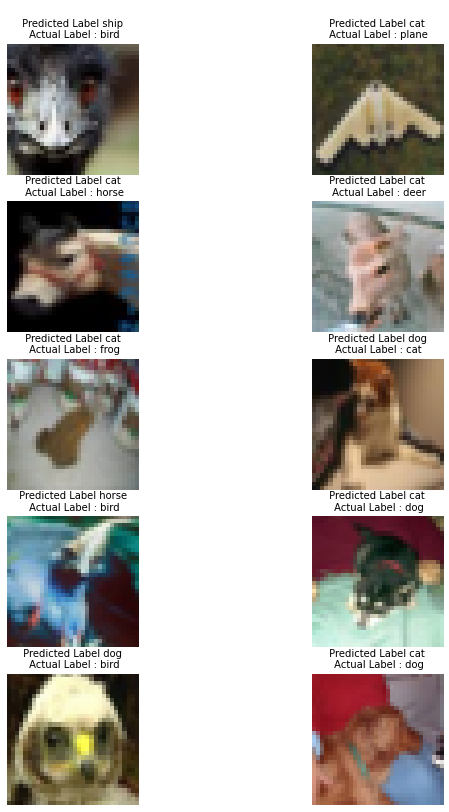

In [27]:
display_incorrect_images(wrong_prediction_list, std,  mean,classes)

Showing plots for train and test losses

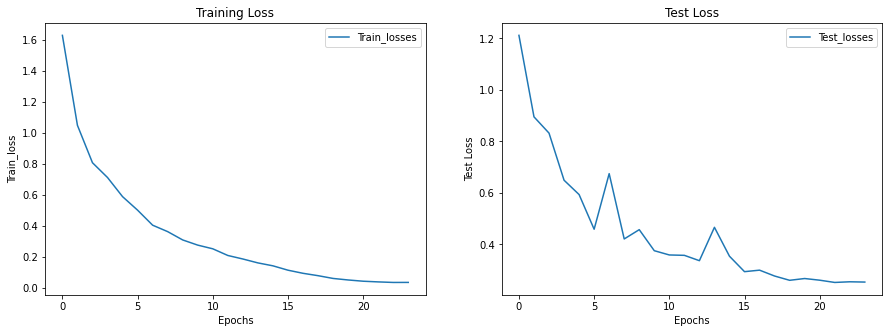

In [28]:
show_plots(train_losses, test_losses)

Showing gradcam output from 10 misclassified images

In [29]:
target_layers = ["layer1", "layer2","layer3"]

In [30]:
torch.autograd.set_detect_anomaly(True)

In [31]:
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], net, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


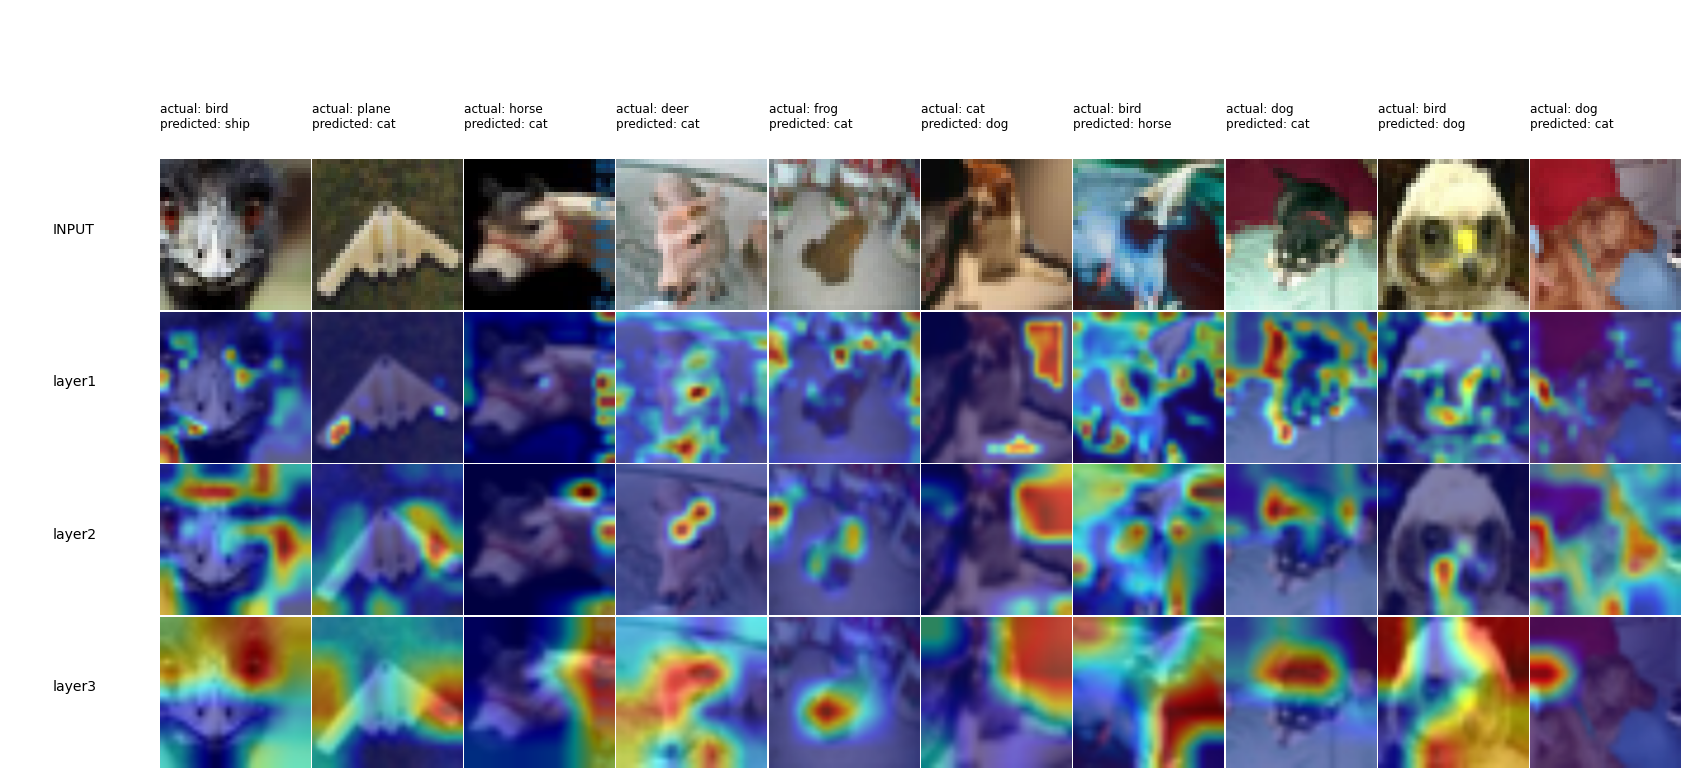

In [32]:
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10], mean, std)